In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
np.random.seed(66)

In [129]:

df=pd.read_csv(r'Tetuan City power consumption.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)
df=df.drop([ 'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],axis=1)

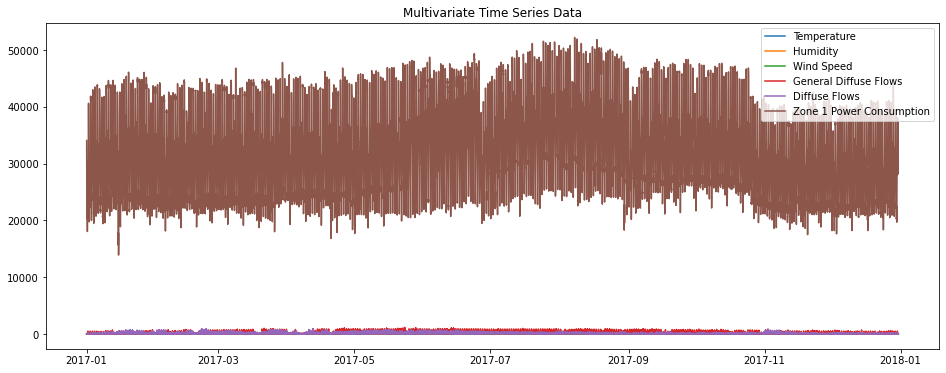

In [130]:

plt.figure(figsize=(16,6))
plt.title('Multivariate Time Series Data')
plt.plot(df.index, df['Temperature'], label='Temperature')
plt.plot(df.index, df['Humidity'], label='Humidity')
plt.plot(df.index, df['Wind Speed'], label='Wind Speed')
plt.plot(df.index, df['general diffuse flows'], label='General Diffuse Flows')
plt.plot(df.index, df['diffuse flows'], label='Diffuse Flows')
plt.plot(df.index, df['Zone 1 Power Consumption'], label='Zone 1 Power Consumption')
plt.legend()
plt.show()

In [131]:
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size, :]
test_data = df.iloc[train_size:, :]


scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

def create_dataset(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y



In [148]:
lookback = 12
X_train, y_train = create_dataset(train_scaled, lookback)
X_test, y_test = create_dataset(test_scaled, lookback)

In [133]:



model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
1179/1179 [==============================] - 19s 12ms/step - loss: 0.0014 - val_loss: 2.6704e-04
Epoch 2/5
1179/1179 [==============================] - 14s 11ms/step - loss: 2.3015e-04 - val_loss: 1.5992e-04
Epoch 3/5
1179/1179 [==============================] - 13s 11ms/step - loss: 1.3060e-04 - val_loss: 9.1743e-05
Epoch 4/5
1179/1179 [==============================] - 13s 11ms/step - loss: 8.7450e-05 - val_loss: 5.5074e-05
Epoch 5/5
1179/1179 [==============================] - 13s 11ms/step - loss: 5.8571e-05 - val_loss: 5.3660e-05


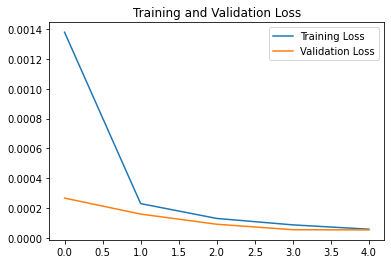

In [134]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [144]:
y_pred = model.predict(X_test)
y_pred = np.concatenate((y_pred, np.zeros((y_pred.shape[0], 5))), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:, 0]


y_test = np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], 5))), axis=1)
y_test = scaler.inverse_transform(y_test)[:,0]


328/328 [==============================] - 2s 5ms/step


In [145]:
from sklearn.metrics import mean_squared_error,r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')
print('r2:',r2_score(y_pred,y_test))

Root Mean Squared Error: 0.26
r2: 0.9957587427253649


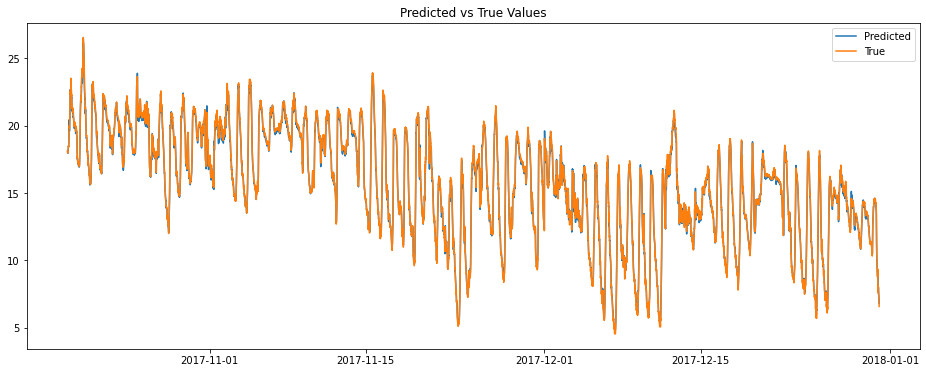

In [146]:
plt.figure(figsize=(16,6))
plt.title('Predicted vs True Values')
plt.plot(test_data.index[lookback:], y_pred, label='Predicted')
plt.plot(test_data.index[lookback:], y_test, label='True')
plt.legend()
plt.show()